<a href="https://colab.research.google.com/github/HUSILEBAI/GEOG-5410/blob/main/GEOG_5410_EOF_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NAO calculation

This is the code for climate mode analysis. Start with connecting your Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Sea Surface Pressure (SLP) data
* Now, let's download the data using <button style="background-color: #f0f0f0; border: 1px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">!curl -O -C</button> command. Here, we use [NCEP/DOE Reanalysis II](https://psl.noaa.gov/data/gridded/data.ncep.reanalysis2.html).

* Note that you only need to run this section once. And you can turn it off after you have your data downloaded.

In [2]:
# !curl -O -C - https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis2/Monthlies/surface/mslp.mon.mean.nc

In [3]:
import glob
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

Now use [xarray.open_dataset](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html) to read monthly mean sea surface pressure dataset.

<button style="background-color: #f0f0f0; border: 1px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">xarray.open_dataset("file_name.nc")</button>


In [4]:
file_name = f"mslp.mon.mean.nc"
# when you only need to read single file
mslp_dat = xr.open_dataset(file_name)
mslp_dat

# when you need to read multiple files
# file = sorted(glob.glob(file_name))
# mslp_dat = xr.open_dataset(file[0])

<xarray.Dataset>
Dimensions:    (lat: 73, lon: 144, time: 542, nbnds: 2)
Coordinates:
  * lat        (lat) float32 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2024-02-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] ...
    mslp       (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    title:          Monthly NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2002/03 by Hoop (netCDF2.3)\nConverted to chunked...

In [5]:
# Reverse the latitude dimension
mslp_dat_reversed_lat = mslp_dat.isel(lat=slice(None, None, -1))
mslp_dat_reversed_lat

<xarray.Dataset>
Dimensions:    (lat: 73, lon: 144, time: 542, nbnds: 2)
Coordinates:
  * lat        (lat) float32 -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2024-02-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] ...
    mslp       (time, lat, lon) float32 ...
Attributes:
    Conventions:    CF-1.0
    title:          Monthly NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2002/03 by Hoop (netCDF2.3)\nConverted to chunked...

In [6]:
# Read the data
lat = mslp_dat_reversed_lat.lat
lon = mslp_dat_reversed_lat.lon
mslp = mslp_dat_reversed_lat.mslp
print(f"Shape of latitude data is {lat.shape}")
print(f"Shape of longitude data is {lon.shape}")
print(f"Shape of mean sea surface pressure data is {mslp.shape}\n")
# print(f"latitude is {lat}")

Shape of latitude data is (73,)
Shape of longitude data is (144,)
Shape of mean sea surface pressure data is (542, 73, 144)



### NAO calculation
Here we use [Hurrell North Atlantic Oscillation (NAO) Index (PC-based)](https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-pc-based) to compute the NAO.

<button style="background-color: #f0f0f0; border: 3px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">DJF mean</button>
<button style="background-color: #f0f0f0; border: 3px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">lat_lim = [20 80]</button>
<button style="background-color: #f0f0f0; border: 3px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">lon_lim = [-90 40]</button>


In [7]:
# extract DJF mslp
mslp_DJF = mslp.where(mslp['time.season']=='DJF', drop=True)
print(f"Shape of mean sea surface pressure data in DJF is {mslp_DJF.shape}")

Shape of mean sea surface pressure data in DJF is (137, 73, 144)


In [8]:
# slice the mslp
lat_slice = slice(20, 80) # if slice(20, 80, -1) -1 is to reverse the latitude dimension

# Define the longitude slicing ranges
lon_slice1 = slice(270, 360)  # Slicing from 270°E to 360°E
lon_slice2 = slice(0, 40)  # Slicing from 0°E to 40°E

# Slice the data along the longitude dimension for each range
mslp_DJF_subset1 = mslp_DJF.sel(lat=lat_slice, lon=lon_slice1)
mslp_DJF_subset2 = mslp_DJF.sel(lat=lat_slice, lon=lon_slice2)

# Concatenate the subsets along the longitude dimension
mslp_DJF_subset = xr.concat([mslp_DJF_subset1, mslp_DJF_subset2], dim='lon')

print(f"Shape of subset of mean sea surface pressure data in DJF is {mslp_DJF_subset.shape}")

Shape of subset of mean sea surface pressure data in DJF is (137, 25, 53)


### EOF analysis

You might need to install eofs package in your colab env. Please run this <button style="background-color: #f0f0f0; border: 3px solid #ccc; padding: 20px 30px; border-radius: 10px; cursor: pointer; font-size: 16px;">!pip install eofs</button>  and install eof function first.

In [9]:
from eofs.xarray import Eof

In [10]:
# Calculate the anomaly of mslp_DJF_subset
mslp_DJF_anomaly = mslp_DJF_subset - mslp_DJF_subset.mean(dim='time')
print(f"Shape of anomaly of the DJF mean sea surface pressure data is {mslp_DJF_anomaly.shape}")

Shape of anomaly of the DJF mean sea surface pressure data is (137, 25, 53)


In [11]:
# Create an EOF solver
solver = Eof(mslp_DJF_anomaly.transpose('time', 'lat', 'lon'))

Shape of EOF 1: (1, 25, 53)
Shape of PC 1: (137, 1)
Shape of NAO index: (137,)


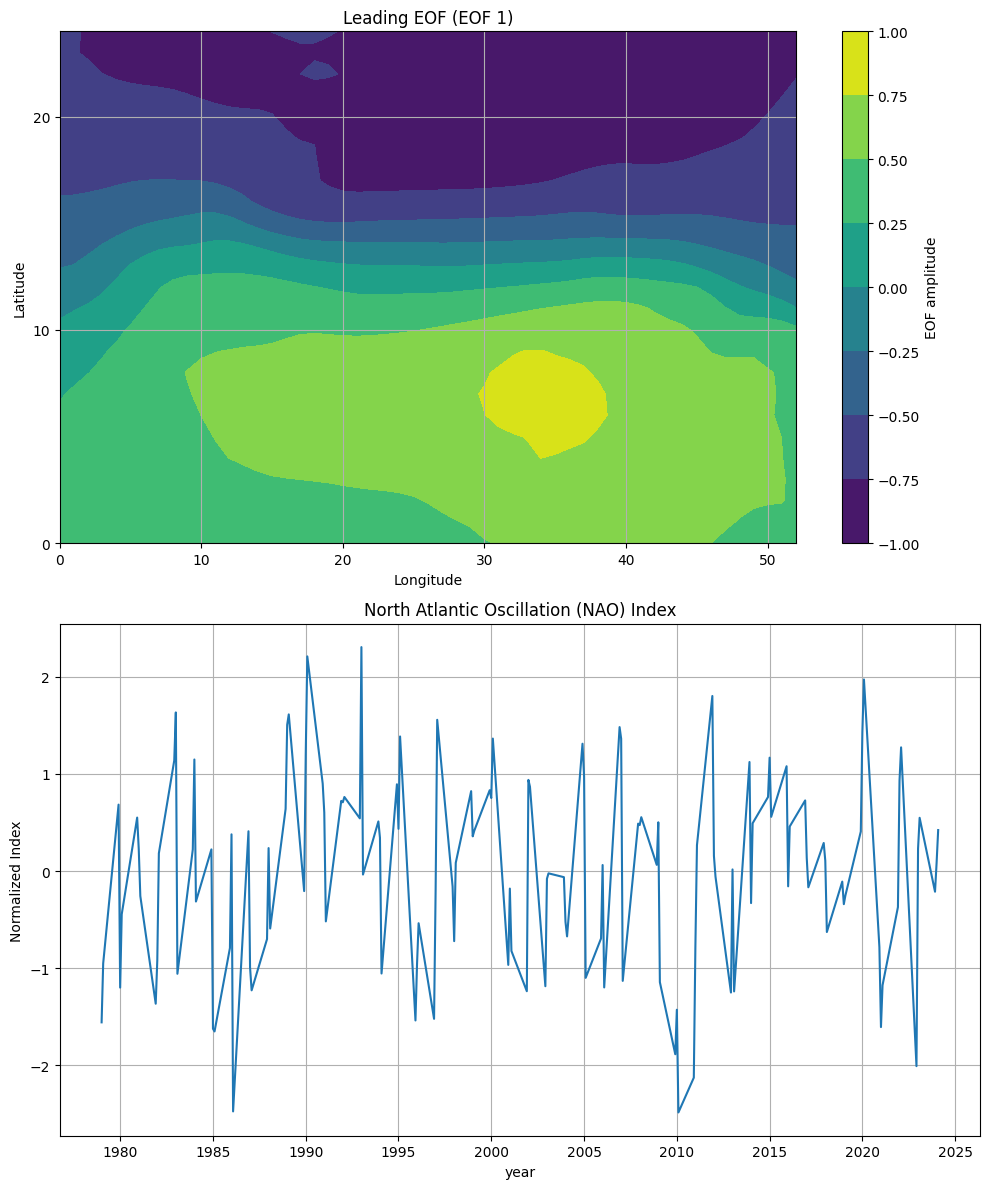

In [12]:
# Retrieve the leading EOF (EOF 1)
eof1 = solver.eofsAsCorrelation(neofs=1)
# Retrieve the PC time series of the leading EOF
pc1 = solver.pcs(npcs=1, pcscaling=1)
# Normalize the NAO index
nao_index_normalized = (pc1.values[:, 0] - np.mean(pc1.values[:, 0])) / np.std(pc1.values[:, 0])

# Print the shape of EOF1 and PC1
print("Shape of EOF 1:", eof1.shape)
print("Shape of PC 1:", pc1.shape)
print("Shape of NAO index:", nao_index_normalized.shape)
# Plot the leading EOF (EOF 1)
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot the EOF
im = axes[0].contourf(eof1[0, :, :])
fig.colorbar(im, ax=axes[0], label='EOF amplitude')
axes[0].set_title('Leading EOF (EOF 1)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_xticks(range(0, eof1.shape[2] + 1, 10))
axes[0].set_yticks(range(0, eof1.shape[1] + 1, 10))
axes[0].grid(True)

# Plot the NAO index time series
axes[1].plot(pc1.time, nao_index_normalized)
axes[1].set_title('North Atlantic Oscillation (NAO) Index')
axes[1].set_xlabel('year')
axes[1].set_ylabel('Normalized Index')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [13]:
# Calculate the Pearson correlation coefficient using NumPy and xarray
corr_coef = xr.corr(mslp_DJF, xr.DataArray(nao_index_normalized, dims='time'), dim='time')


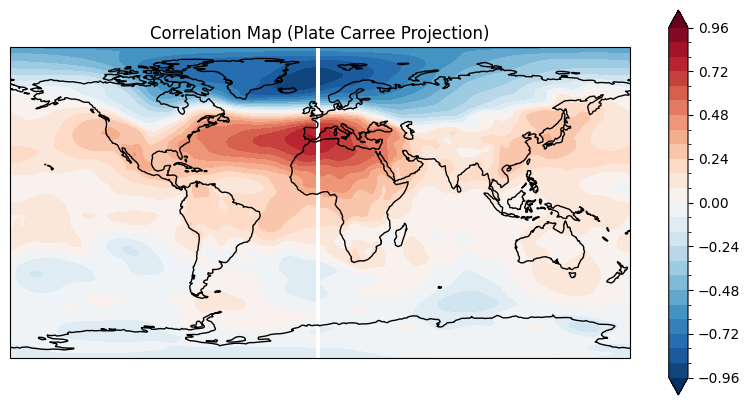

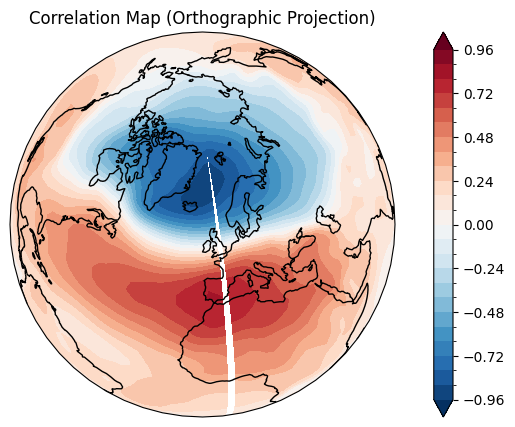

In [14]:
plt.figure(figsize=(10, 5))
ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
cp1 = corr_coef.plot.contourf(levels=30, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
plt.title('Correlation Map (Plate Carree Projection)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax1.coastlines()
plt.grid(True)
plt.show()

# Plot the correlation map with Orthographic projection
plt.figure(figsize=(10, 5))
ax2 = plt.axes(projection=ccrs.Orthographic(central_longitude=-10, central_latitude=60))
cp2 = corr_coef.plot.contourf(levels=30, cmap='RdBu_r', extend='both', transform=ccrs.PlateCarree())
plt.title('Correlation Map (Orthographic Projection)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax2.coastlines()
plt.grid(True)
plt.show()
